# Transfer Learning for Image Classification

In [12]:
# general
import glob
from pathlib import Path
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# torch
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# images
import cv2 as cv

In [13]:
# setup 
sns.set(
    style="whitegrid",
    palette="muted",
    font_scale=1.2
)

# color palette
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# seeding everything
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
train_path = "data/GTSRB/Final_Training/Images/*"
train_folder = sorted(glob.glob(train_path))

In [15]:
train_folder

['data/GTSRB/Final_Training/Images/00000',
 'data/GTSRB/Final_Training/Images/00001',
 'data/GTSRB/Final_Training/Images/00002',
 'data/GTSRB/Final_Training/Images/00003',
 'data/GTSRB/Final_Training/Images/00004',
 'data/GTSRB/Final_Training/Images/00005',
 'data/GTSRB/Final_Training/Images/00006',
 'data/GTSRB/Final_Training/Images/00007',
 'data/GTSRB/Final_Training/Images/00008',
 'data/GTSRB/Final_Training/Images/00009',
 'data/GTSRB/Final_Training/Images/00010',
 'data/GTSRB/Final_Training/Images/00011',
 'data/GTSRB/Final_Training/Images/00012',
 'data/GTSRB/Final_Training/Images/00013',
 'data/GTSRB/Final_Training/Images/00014',
 'data/GTSRB/Final_Training/Images/00015',
 'data/GTSRB/Final_Training/Images/00016',
 'data/GTSRB/Final_Training/Images/00017',
 'data/GTSRB/Final_Training/Images/00018',
 'data/GTSRB/Final_Training/Images/00019',
 'data/GTSRB/Final_Training/Images/00020',
 'data/GTSRB/Final_Training/Images/00021',
 'data/GTSRB/Final_Training/Images/00022',
 'data/GTSR

In [16]:
# helpers
def load_image(img_path, resize=True):
    img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)

    if resize:
        img = cv.resize(img, (64, 64), interpolation=cv.INTER_AREA)
    
    return img

def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis('off')

def show_sign_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    # putting the images on the correct format: 
    # batch x channels x width x height
    images = images.permute(0, 3, 1, 2)
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.figure(figsize=(24, 12))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

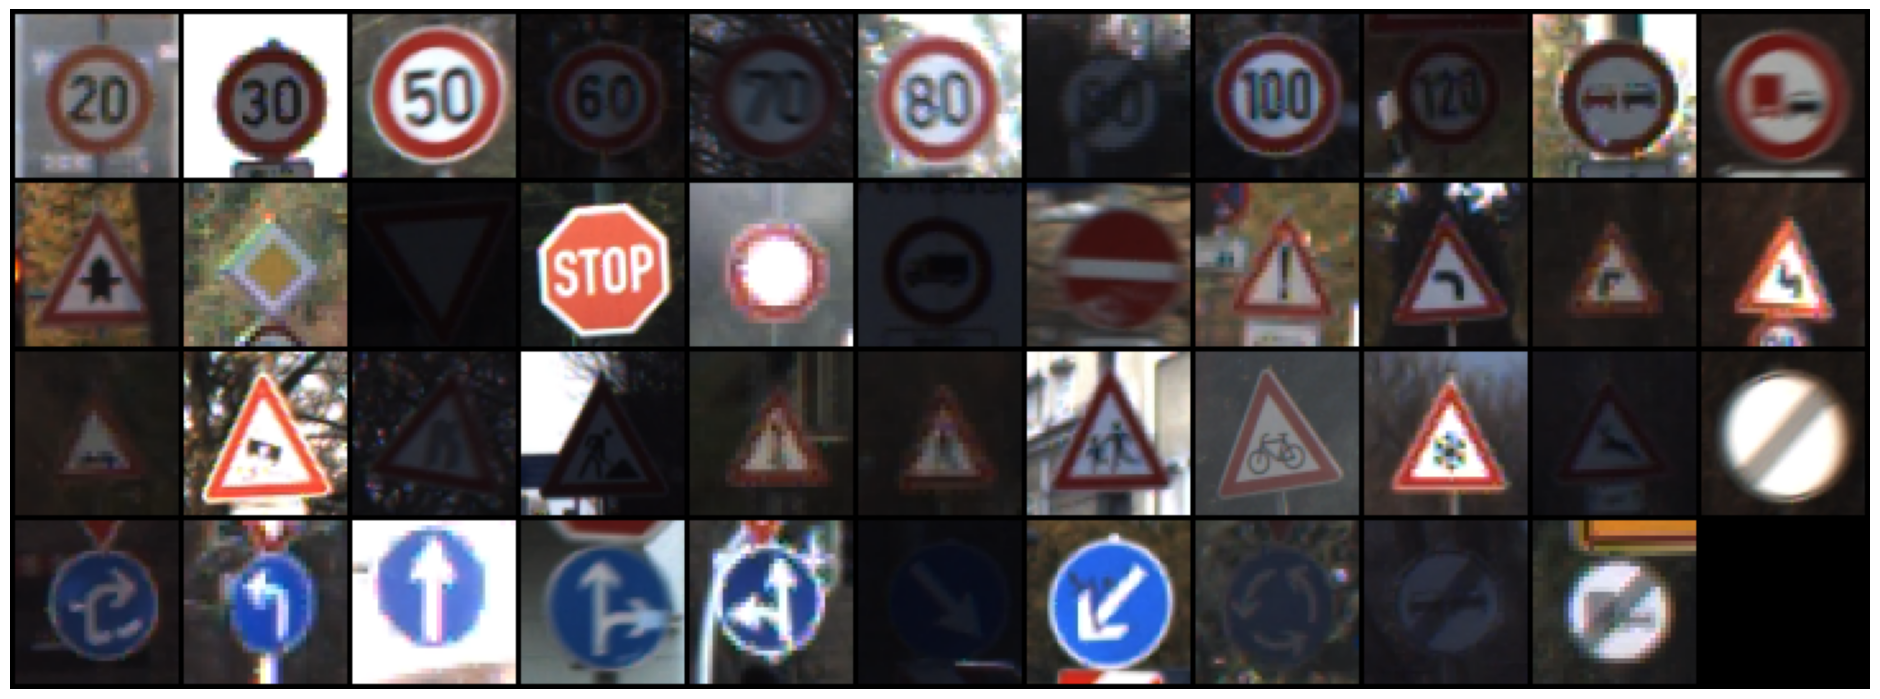

In [17]:
sample_images = [np.random.choice(glob.glob(f'{tf}/*ppm')) for tf in train_folder]
show_sign_grid(sample_images)

We have a total of 40 classes, but here will be looking just at some classes:
- priority_road: 12
- give_way: 13
- stop: 14
- no_entry: 17

In [18]:
DATA_DIR = Path('data', 'gtsrb_training')
DATASETS = ['train', 'val', 'test']
CLASSES_NAMES = ['priority_road', 'give_way', 'stop', 'no_entry']
CLASSES_INDICES = [12, 13, 14, 17]

for dataset in DATASETS:
    for classe in CLASSES_NAMES:
        DATA_DIR.joinpath(dataset, classe).mkdir(parents=True, exist_ok=True)


If you run this code more than one time in a row, will end up with duplicate images on those folders

In [19]:
# we'll reserve 80% of the images for training, 10% validation
# 10% for test
OLD_DATA_PATH = "data/GTSRB/Final_Training/Images/"
for i, class_idx in enumerate(CLASSES_INDICES):
    origin_folder_name = str(class_idx).zfill(5)
    image_paths = np.array(glob.glob(OLD_DATA_PATH + origin_folder_name + '/*.ppm'))
    print("{}: {}".format(CLASSES_NAMES[i], len(image_paths)))
    
    # randomize our sample to do the split
    np.random.shuffle(image_paths)

    # splitting the data first in 80% and after in 90%
    # 80/10/10 
    dataset_split = np.split(
        image_paths,
        indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
    )
    
    dataset_data = zip(DATASETS, dataset_split)
    
    for dataset_section, img_paths in dataset_data:
        for img_path in img_paths:
            shutil.copy(img_path, DATA_DIR.joinpath(dataset_section, CLASSES_NAMES[i]))


priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


In [20]:
# collecting means and std of pixels on training images
# for each of the classes we have
transformers_dataset = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])
image_dataset = torchvision.datasets.ImageFolder(root="data/gtsrb_training/train/", transform=transformers_dataset)

In [21]:
dataloader = DataLoader(image_dataset, 
                            batch_size=len(image_dataset),
                            shuffle=False,
                            num_workers=3)

In [22]:
def mean_std_loader(loader):
    images, labels = next(iter(loader))
    mean, std = images.mean([0, 2, 3]), images.std([0, 2, 3])
    return mean, std

mean, std = mean_std_loader(dataloader)
print("mean: {}, std: {}".format(mean, std))

mean: tensor([0.3995, 0.3543, 0.3492]), std: tensor([0.2919, 0.2811, 0.2810])


mean: tensor([0.3995, 0.3543, 0.3492]), std: tensor([0.2919, 0.2811, 0.2810])

In [23]:
mean_nums = [0.3995, 0.3543, 0.3492]
std_nums = [0.2919, 0.2811, 0.2810]

In [24]:
# transformers for the actually training
transformers_train_val_test = {
    "train": transforms.Compose([ 
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_nums, std=std_nums)
    ]),
    "val": transforms.Compose([ 
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_nums, std=std_nums)
    ]),
    "test": transforms.Compose([ 
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_nums, std=std_nums)
    ]),
}